# **Chap3：卷积神经网络**

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

2023-04-16 11:34:29.382102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 11:34:29.629361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 11:34:30.249214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/media/hdd/nzliao/2027/software/miniconda3/envs/tensorflow/lib/
2023-04-16 11:34:30.249341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'

In [ ]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=12)

## **3.1 图像分类任务**

### **3.1.1 图像分类数据集介绍**

计算机视觉中的一个最基本任务就是图像分类，我们以固定大小的图片像素作为输入（每张图像的维度为 $W\times H\times C$，其中，$W,H$ 分别表示宽和高，$C$ 表示通道数，通常来说，对于无颜色信息的灰度图像，$C = 1$，该维度通常会被忽略，而对于有颜色信息的彩色图像，$C = 3$分别表示R，G，B三种颜色通道）

机器学习任务中有很多经典的图像分类数据集，例如：
* `MNIST`：手写数字识别，包含0~9共10个数字的**灰度图像**，共10个类别，图像尺寸`28 * 28`
* `FASHION-MNIST`：衣物识别，包含外套，裤子，鞋子等衣物**灰度图像**，共10个类别，图像尺寸`28 * 28`
* `CIFAR-10`：由 Hinton 的学生 Alex 和 Ilya 整理的一个用于识别普适物体的小型数据集，包括飞机、汽车、鸟类、猫等共10个类别的**彩色RGB图像**，图像尺寸`32 * 32 * 3`
* `CIFAR-100`：这是对`CIFAR-10`数据集的扩展，图像类别种类更多，包含哺乳动物、鱼类、花卉、食品容器等生活中丰富的**彩色RGB图像**，图像尺寸`32 * 32 * 8`

上述四个数据集的分类难度逐渐升高，且数据集规模适中，适合作为我们学习深度学习模型时所使用的数据集

我们可以使用`tf.keras.datasets`下载并导入这几个数据集

In [2]:
# 导入 Fashion Mnist 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

通过`.shape`查看数据维度，可以看到训练集包含 60000 个样本，测试集包含 10000 个样本

In [3]:
print("训练集数据维度：",x_train.shape)
print("测试集数据维度：",x_test.shape)

训练集数据维度： (60000, 28, 28)
测试集数据维度： (10000, 28, 28)


`plt.imshow()`可以帮助我们绘制图像信息，进行观察

In [4]:
def show_images(images : list, labels : list, pred_labels : list=None, 
                nrows: int=1, ncols : int=5, figsize : tuple=None):
    if figsize is None:
        figsize = (2.5*ncols,2.5*nrows) # 设置 figsize
    # 创建子图
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize) 
    ax = ax.flatten()

    if pred_labels is None:
        pred_labels = [None for _ in range(len(labels))]
    # 在每个子图上绘制图像，并展示标签
    for i, (image,label,pred) in enumerate(zip(images,labels,pred_labels)):
        ax[i].imshow(image)
        ax[i].set_title("Label: %s\nPred: %s"%(label,pred))

    plt.tight_layout()

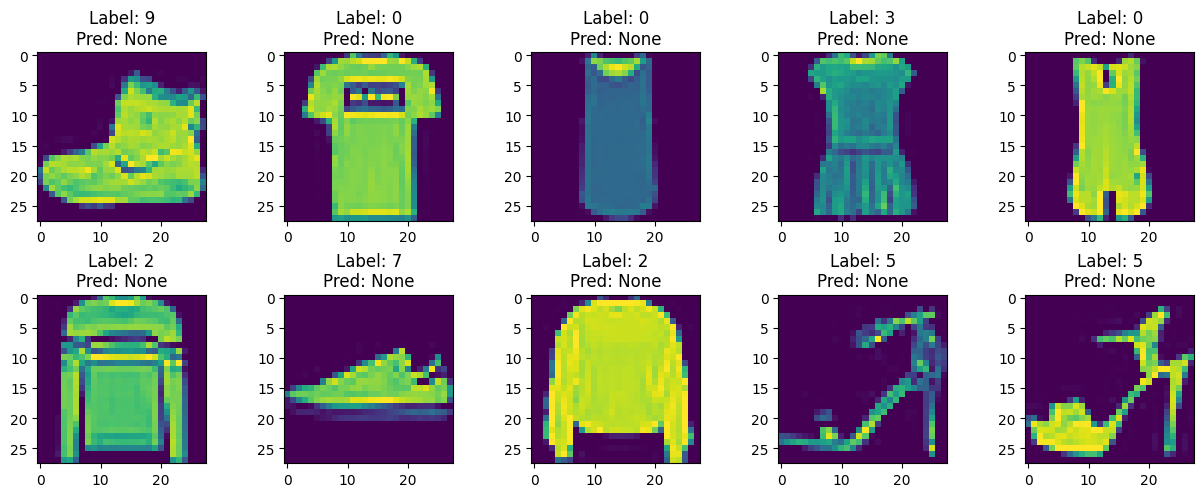

In [5]:
show_images(x_train[0:10],y_train[0:10],nrows=2,ncols=5)

函数`show_images()`已经写入`../source/code/utils.py`，可以随时调用

### **3.1.2 Baseline模型：全连接网络**

我们用之前学过的知识，搭建一个**全连接神经网络**来完成`Fashion-Mnist`图像分类任务，注意，由于这里图像是二维输入，而`Dense()`全连接网络没法直接处理二维特征，因此，我们需要先将图像输入**拉直**成为一个向量，这可以通过`tf.keras.layers.flatten()`实现

In [22]:
class BaselineModel(tf.keras.Model):
    def __init__(self, hidden_layers : list, num_class : int, dropout : float=0.25, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flat = tf.keras.layers.Flatten() # 拉直层
        # 中间的隐藏层
        self.dense_layers = []
        for hidden_size in hidden_layers:
            self.dense_layers.append(
                tf.keras.layers.Dense(hidden_size,activation="relu")
            ) # append 添加每一个隐藏层
            self.dense_layers.append(
                tf.keras.layers.Dropout(rate=dropout)
            ) # 每层隐藏层之后添加 Dropout
        
        # 最后的输出层
        self.output_dense = tf.keras.layers.Dense(num_class)
        self.softmax = tf.keras.layers.Softmax() # Softmax 转换为概率分布

    # 定义前向计算图，即模型的推理过程
    def call(self, inputs, training=None, mask=None):
        X = self.flat(inputs) # 拉直
        # 依次通过每一层隐藏层
        for layer in self.dense_layers:
            X = layer(X)
        Y = self.output_dense(X)

        # 输出概率分布，维度为 (B, num_class)
        # B 表示批量大小
        return self.softmax(Y) 

这个模型作为**基线模型**（Baseline Model），我们后续的学习应该不断进步，打败这个基础模型

我们再定义一个函数`classification_predict()`来实现给定特征，让模型做出预测，我们会看到模型是**按照批量**对数据做出预测的，这样做的目的在于**防止显存溢出**:
* 深度学习模型和之前接触的机器学习模型不同，在模型的预测和推理阶段，**如果我们一次性对所有的样本做出预测，则可能会导致显存溢出**
* 因此一种**稳妥的做法是采用批量处理**的思想，将待推理的数据集切分为多个批量，每次预测一个批量，最终再将结果进行汇总

In [7]:
def classification_predict(model : tf.keras.Model, inputs : tuple, batch_size : int=32, label : bool=True):
    # 创建批量数据生成器
    data_iter = tf.data.Dataset.from_tensor_slices(inputs).batch(batch_size)

    y_pred = []
    for batch in data_iter:
        y_pred.append(model(*batch))
    
    # 拼接预测结果
    y_pred = tf.concat(y_pred,axis=0)

    # 是否将预测概率转换为标签
    if label:
        y_pred = tf.argmax(y_pred,axis=-1)
    
    return y_pred

函数`classification_predict()`已经写入`../source/code/utils.py`

然后，定义图像分类任务的训练函数`train()`，这个训练函数将贯穿整个第三章，因为训练逻辑不需要更改，这个函数已经被写入`../source/code/ch3.py`

In [8]:
def train(model, train_tensors : tuple, test_tensors : tuple, 
          batch_size : int=64, epochs : int=10, lr : float=0.01, verbose : int=1):
    """
    Parameters
    ----------
    train_tensors, test_tensors : tuple
        训练 / 测试数据的 `tf.Tensor` 元组，元组包含两个元素\n
        `tensors[0]` 表示输入特征，`tensors[1]` 表示标签
    """
    # 创建损失函数和优化器
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # 度量函数
    accuracy = tf.keras.metrics.categorical_accuracy
    
    # 创建动画实例
    animator = utils.Animator(xlabel="Epochs",legend=(("train loss",),("train acc","test acc")),
                        xlim=[1,epochs],ncols=2,figsize=(10,4),fmts=(("-",),("m--","g-,"))) 

    for epoch in range(epochs):
        batch_data = tf.data.Dataset.from_tensor_slices(train_tensors).\
            batch(batch_size).shuffle(batch_size)
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                prob = model(x_batch,training=True)
                loss = loss_func(y_batch,prob)
            
            # 选择参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights))
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            # 做出预测
            y_train_prob = classification_predict(
                model,(train_tensors[0],),batch_size,label=False)
            y_test_prob = classification_predict(
                model,(test_tensors[0],),batch_size,label=False)
            
            train_loss = tf.reduce_mean(loss_func(train_tensors[1],y_train_prob)).numpy()
            train_acc = tf.reduce_mean(accuracy(train_tensors[1],y_train_prob)).numpy()
            test_acc = tf.reduce_mean(accuracy(test_tensors[1],y_test_prob)).numpy()

            animator.add(epoch+1,(train_loss,),ax=0) # 子图1
            animator.add(epoch+1,(train_acc,test_acc),ax=1) # 子图2
    
    return model

在开始训练之前，我们还需要对数据做预处理，图片的像素范围是`[0, 255]`，我们需要做一次缩放，处于数值稳定性的考虑，将它们转换到`[0, 1]`或者`[-1, 1]`范围内

In [9]:
x_train, x_test = x_train / 255, x_test / 255 # 转换到 [0, 1]

此外，交叉熵损失函数`CategoricalCrossentropy()`需要多类别标签`y`进行One-Hot编码成为向量

In [10]:
# 对标签进行 One-Hot 编码
num_class = 10
y_train = tf.one_hot(y_train,depth=num_class)
y_test = tf.one_hot(y_test,depth=num_class)

In [11]:
# 查看 One-Hot 编码的标签
y_train[0:5]

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

接下来，创建一个隐藏层大小为`[256,256,128]`的神经网络，训练模型

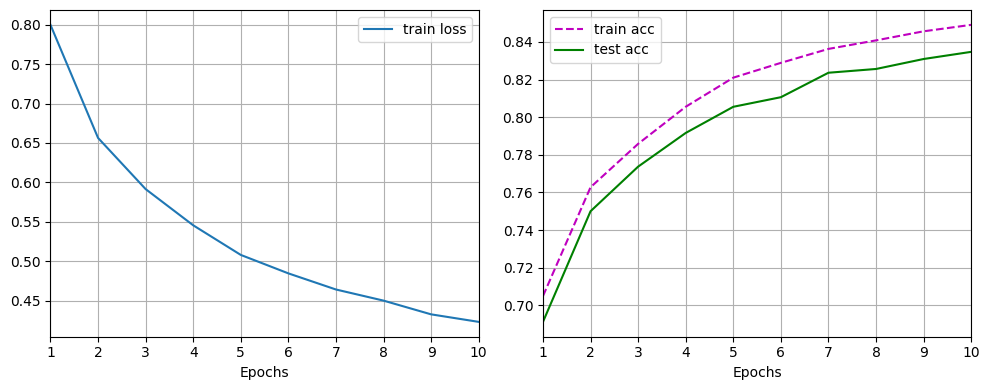

In [12]:
# 创建模型
model = BaselineModel(hidden_layers=[256,256,128],num_class=10)
# 进行训练
model = train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
              batch_size=128,epochs=10)

下面我们在测试集上测试一下模型的预测效果

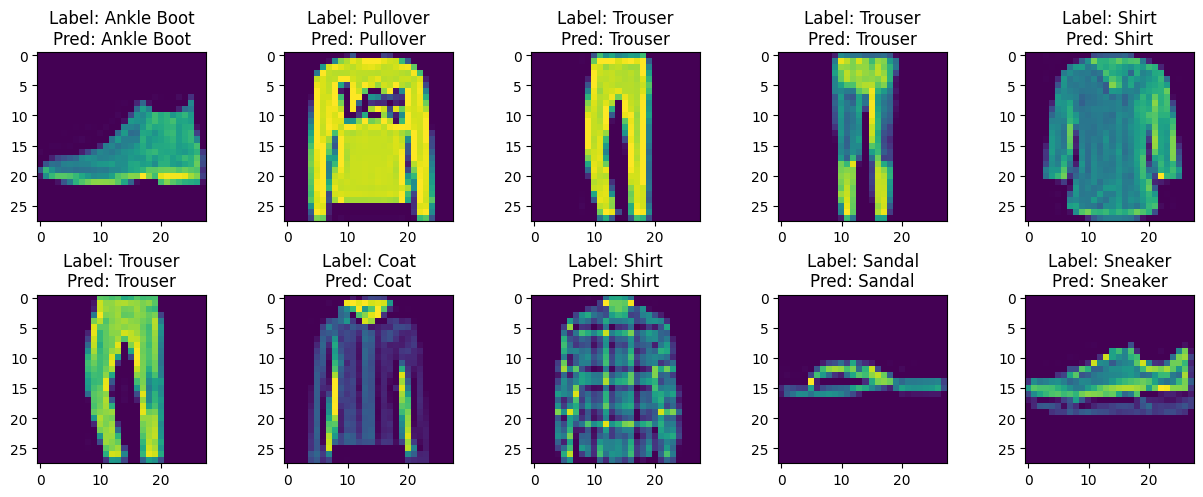

In [13]:
# 进行预测
y_pred = classification_predict(model,inputs=(x_test[0:10],)).numpy()
labels = tf.argmax(y_test[0:10],axis=-1).numpy().flatten()
utils.show_images(images=x_test[0:10],labels=labels,pred_labels=y_pred,
                  nrows=2,ncols=5,label_names=ch3.FASHION_MNIST_labels)

可以看到，我们的全连接神经网络模型在这个简单的任务上，预测还是非常准确的

我们更换一下数据集，尝试一下更为困难的`CIFAR100`数据集

In [2]:
# 导入 CIFAR-100 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
print("训练集特征形状：",x_train.shape)
print("训练集标签形状：",y_train.shape)
# 对数据做规范化
x_train, x_test = x_train / 255, x_test / 255 # 转换到 [0, 1]

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


In [3]:
# 对标签进行编码
num_class = 100
y_train = tf.one_hot(y_train.flatten(),depth=num_class)
y_test = tf.one_hot(y_test.flatten(),depth=num_class)

数据集导入和预处理已经写入`../source/code/ch3.py`

绘制几个样本，观察图像，这些图像都是**彩色的RGB三通道图像**

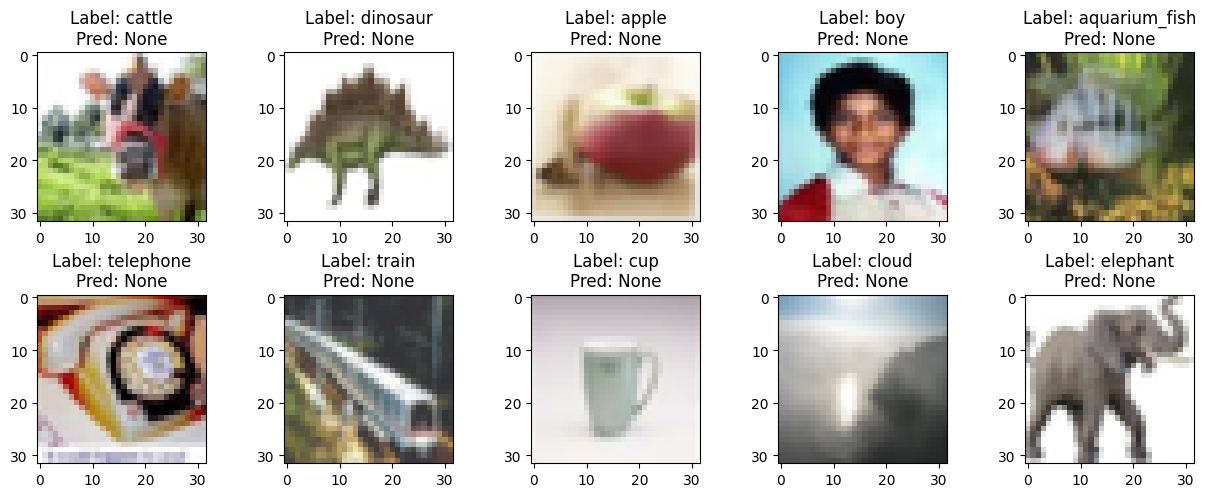

In [16]:
labels = tf.argmax(y_train[0:10],axis=-1).numpy()
utils.show_images(images=x_train[0:10],labels=labels,
                  nrows=2,ncols=5,label_names=ch3.CIFAR100_labels)

下一步，创建模型，进行训练

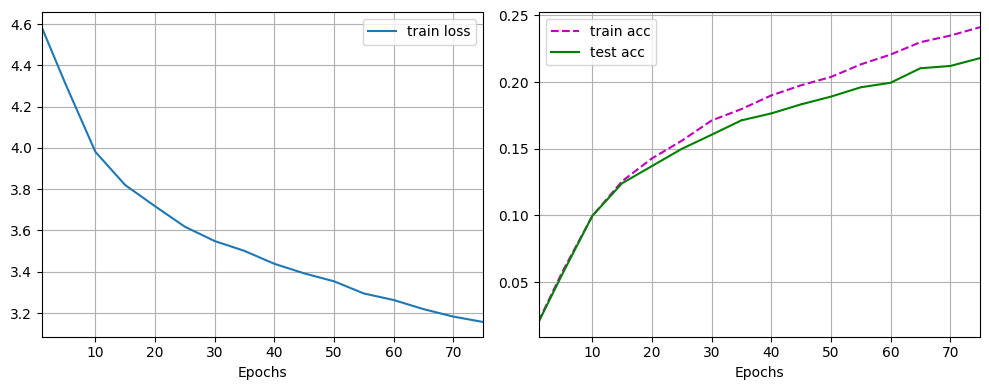

In [17]:
# 创建模型
model = BaselineModel(hidden_layers=[256,256,128],num_class=100)
# 进行训练
model = train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
              batch_size=128,epochs=75,verbose=5)

模型的正确率大约为20%，我们可以观察模型在测试集上的表现，可以看到**模型大量的混淆行为**

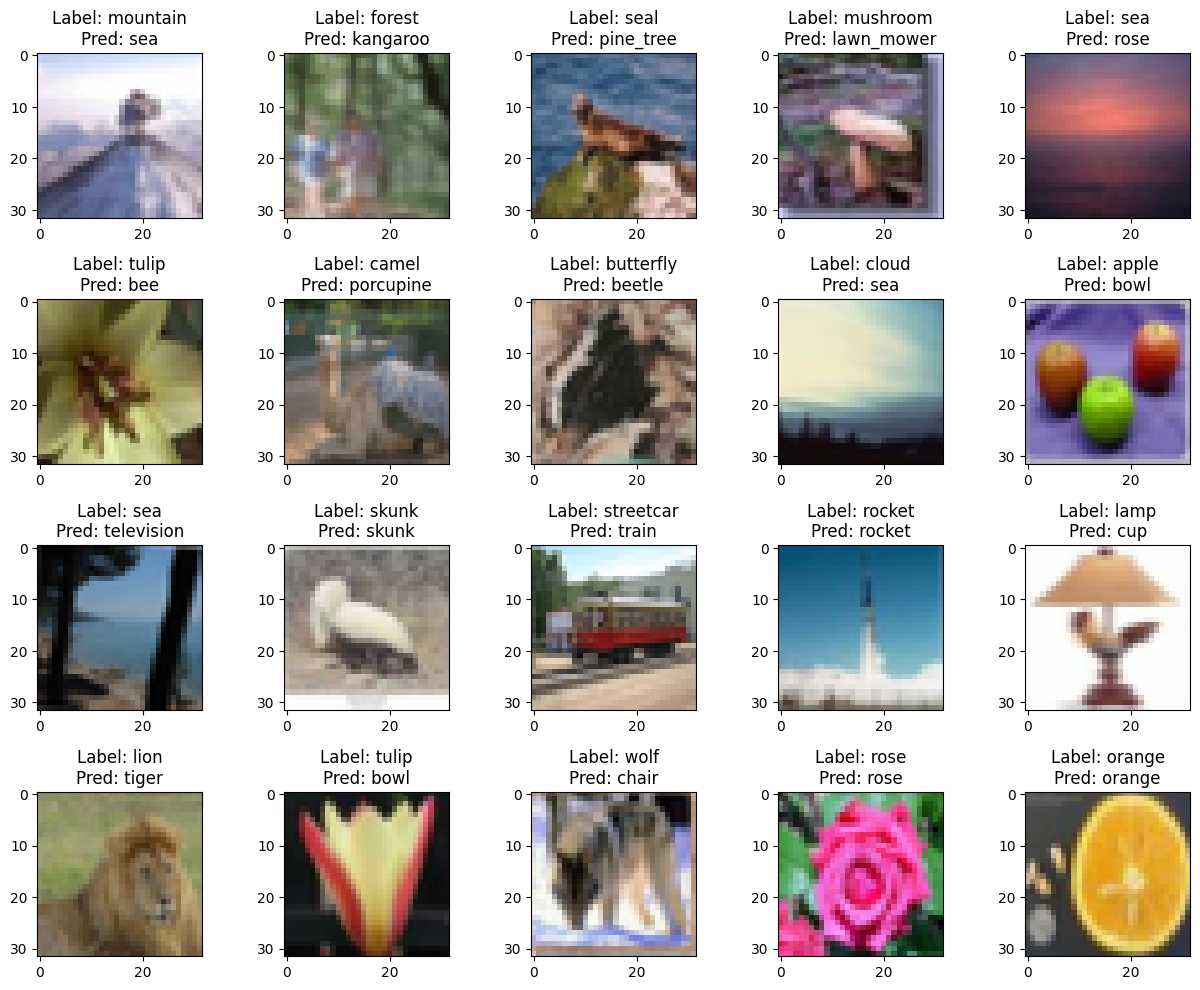

In [18]:
# 进行预测
y_pred = classification_predict(model,inputs=(x_test[0:20],)).numpy()
labels = tf.argmax(y_test[0:20],axis=-1).numpy().flatten()
utils.show_images(images=x_test[0:20],labels=labels,pred_labels=y_pred,
                  nrows=4,ncols=5,label_names=ch3.CIFAR100_labels)

下面，我们将介绍**计算机视觉中的基础框架，卷积神经网络**，以提升模型在`CIFAR100`数据集上的准确率

----